# Кластеризация ЕГЭ (8.5 если сделаны все задачи)

Рядом лежат экселевские таблицы с координатами точек. В 3 и 4 задаче используется манхетеское расстояние. В остальных Евклидово.

* Постройте Распределение точек
* Кластеризуйте руками
* Постройте Распределение точек, отметьте принадлежность кластеров цветами
* Найдите среди в каждом кластере точку расстояние от которой до всех остальных минимально
* Выведите усреднение центров всех кластеров * 1000

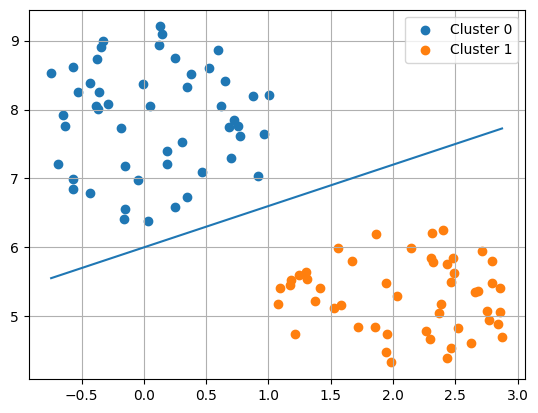

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# загрузка Excel
df = pd.read_excel("0.xls")
df = df.iloc[:, :2]
df.columns = ['x', 'y']

df['cluster'] = np.where(df['y'] > 0.6 * df['x'] + 6, 0, 1)

x_line = np.linspace(df.x.min(), df.x.max(), 100)
y_line = 0.6 * x_line + 6

plt.scatter(df[df.cluster == 0]['x'], df[df.cluster == 0]['y'], label='Cluster 0')
plt.scatter(df[df.cluster == 1]['x'], df[df.cluster == 1]['y'], label='Cluster 1')
plt.plot(x_line, y_line)

plt.grid(True)
plt.legend()
plt.show()

# Кластеризация (0.75 за каждый алгоритм на всех данных)

На предложенных распределениях данных проверьте предложенные алгоритмы. Постройте графики кластеризации для каждой пары алгоритм-данные, разные кластеры покрасьте разным цветом. Воспользуйтесь sklearn реализациями. Параметры кластеризации для разных алгоритмов подберите такие, чтобы алгоритмы можно было сравнивать (по возможности одинаковое количество кластеров и т.д.)

In [ ]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

In [ ]:
two_means =
dbscan =

clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means),
        ("DBSCAN", dbscan),
    )

In [ ]:
np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 10,
    "n_clusters": 3,
    "min_samples": 20,
    "xi": 0.05,
    "min_cluster_size": 0.1,
}

datasets = [
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 20,
            "xi": 0.25,
        },
    ),
    (noisy_moons, {"damping": 0.75, "preference": -220, "n_clusters": 2}),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 5,
            "xi": 0.035,
            "min_cluster_size": 0.2,
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 20,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    (blobs, {}),
    (no_structure, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    for name, algorithm in clustering_algorithms:
        t0 = time.time()